In [ ]:
!pip install tensorflow==2.15.1
!pip install tensorflow-recommenders==0.7.3

# Summary

In my previous work (Level 2), I introduced additional features to enhance the performance of both retrieval and ranking models, aiming to improve categorical accuracy. This time, I tested the model under different configurations to further improve the model performance.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)
plt.style.use("ggplot")

In [ ]:
!wget https://raw.githubusercontent.com/imsreecharan/datasets_/refs/heads/master/amazon_reviews.csv

In [4]:
reviews = pd.read_csv('amazon_reviews.csv',index_col = 0).rename(columns = {'asin': 'product_id'})[["product_id","overall","reviewerID","summary"]]
reviews.head()

,product_id,overall,reviewerID,summary
0,0528881469,5.0,AO94DHGC771SJ,Gotta have GPS!
1,0528881469,1.0,AMO214LNFCEI4,Very Disappointed
2,0528881469,3.0,A3N7T0DY83Y4IG,1st impression
3,0528881469,2.0,A1H8PY3QHMQQA0,"Great grafics, POOR GPS"
4,0528881469,1.0,A24EV6RXELQZ63,"Major issues, only excuses for support"


In [5]:
unique_product_id = np.unique(reviews["product_id"])
unique_reviewerID = np.unique(reviews["reviewerID"])

In [6]:
retrieval_dataset = tf.data.Dataset.from_tensor_slices({
    "reviewerID": reviews["reviewerID"].values,
    "product_id": reviews["product_id"].values,
    "summary": reviews["summary"].values
})

candidate_dataset = tf.data.Dataset.from_tensor_slices({"product_id": unique_product_id})

shuffled = retrieval_dataset.shuffle(len(retrieval_dataset), seed=42, reshuffle_each_iteration=False)
train_retrieval = shuffled.take(int(len(retrieval_dataset) * 0.8)).batch(32)
test_retrieval = shuffled.skip(int(len(retrieval_dataset) * 0.8)).batch(32)

# 1. Product Model

In [7]:
product_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary = unique_product_id),
    tf.keras.layers.Embedding(len(unique_product_id) + 1, 32)
])

print(product_model(reviews["product_id"][0]))
print(tf.expand_dims(product_model(reviews["product_id"][0]),axis = 0))

tf.Tensor(
[-0.03893324  0.02205348 -0.00592859 -0.01549635  0.0001187   0.03894453
  0.04090737 -0.00895988 -0.04143807 -0.02681702 -0.01438829  0.01618813
  0.04840655 -0.04571145 -0.0039338   0.01232658  0.00637271  0.03640929
  0.0269005   0.02377191 -0.02187345  0.00657569  0.04839664 -0.03085066
 -0.00026476  0.027358    0.00216546 -0.01973563 -0.01814598  0.01331301
  0.02251944  0.00212345], shape=(32,), dtype=float32)
tf.Tensor(
[[-0.03893324  0.02205348 -0.00592859 -0.01549635  0.0001187   0.03894453
   0.04090737 -0.00895988 -0.04143807 -0.02681702 -0.01438829  0.01618813
   0.04840655 -0.04571145 -0.0039338   0.01232658  0.00637271  0.03640929
   0.0269005   0.02377191 -0.02187345  0.00657569  0.04839664 -0.03085066
  -0.00026476  0.027358    0.00216546 -0.01973563 -0.01814598  0.01331301
   0.02251944  0.00212345]], shape=(1, 32), dtype=float32)


# 2. Summary Model (Text Vectorization + Embedding + GlobalAverage1D)

In [8]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = 10000)
text_vectorizer.adapt(reviews["summary"].values)
text_vectorizer(reviews["summary"][0])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([869,  69, 384])>

In [9]:
summary_model = tf.keras.Sequential([text_vectorizer,
                                     tf.keras.layers.Embedding(10000, 32,mask_zero = True),
                                     tf.keras.layers.GlobalAveragePooling1D()])
summary_model(tf.constant([reviews["summary"][0]]))

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.00562282, -0.01156177, -0.01599142, -0.00744659,  0.03009556,
         0.01319853, -0.00578088,  0.01709627, -0.00713371, -0.01943078,
         0.00764798, -0.00212888,  0.03274184, -0.00526212,  0.02633273,
         0.00157252, -0.00972246,  0.01191218,  0.00802399,  0.01660219,
        -0.00258707,  0.00045978, -0.00496537, -0.02029037, -0.01907158,
        -0.01587055,  0.00832057, -0.01859292, -0.01675697,  0.0130671 ,
        -0.00443221, -0.01519292]], dtype=float32)>

# 3. User Model

In [10]:
user_model = tf.keras.Sequential([tf.keras.layers.StringLookup(vocabulary = unique_reviewerID),
                                  tf.keras.layers.Embedding(len(unique_reviewerID) + 1, 32)])

print(user_model(reviews["reviewerID"][0]))
print(tf.expand_dims(user_model(reviews["reviewerID"][0]),axis = 0))

tf.Tensor(
[ 0.01926969  0.00766212 -0.0496311   0.00571853  0.02964571  0.02523352
 -0.00594863  0.0103463   0.02174259 -0.0022824  -0.03851752  0.01790694
 -0.04087858 -0.01050769 -0.00120596  0.03245696 -0.00833708  0.01270822
 -0.04038792 -0.00601699  0.00828858 -0.0178817  -0.02898265  0.02108169
  0.01060699 -0.04032623  0.0420214  -0.02220415  0.0332051   0.00453446
 -0.0462868  -0.03849055], shape=(32,), dtype=float32)
tf.Tensor(
[[ 0.01926969  0.00766212 -0.0496311   0.00571853  0.02964571  0.02523352
  -0.00594863  0.0103463   0.02174259 -0.0022824  -0.03851752  0.01790694
  -0.04087858 -0.01050769 -0.00120596  0.03245696 -0.00833708  0.01270822
  -0.04038792 -0.00601699  0.00828858 -0.0178817  -0.02898265  0.02108169
   0.01060699 -0.04032623  0.0420214  -0.02220415  0.0332051   0.00453446
  -0.0462868  -0.03849055]], shape=(1, 32), dtype=float32)


# 4. Stacking the Models in a Class Object

In [11]:
class UserModel(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.user_model = tf.keras.Sequential([tf.keras.layers.StringLookup(vocabulary = unique_reviewerID),
                                           tf.keras.layers.Embedding(len(unique_reviewerID) + 1, 32)])

    self.text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = 10000)
    self.text_vectorizer.adapt(reviews["summary"].values)

    self.summary_model = tf.keras.Sequential([self.text_vectorizer,
                                              tf.keras.layers.Embedding(10000, 32,mask_zero = True),
                                              tf.keras.layers.GlobalAveragePooling1D()])

  def call(self,inputs):
    return tf.concat([self.user_model(inputs["reviewerID"]),
                     self.summary_model(inputs["summary"])],axis = 1)





In [12]:
UserModel()(next(iter(train_retrieval.unbatch().take(1).batch(1))))

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[ 1.5414212e-02,  4.8864808e-02,  9.0056658e-04,  2.3151066e-02,
         6.6760890e-03, -2.4441540e-02, -6.1950795e-03, -3.5896838e-02,
        -2.0220889e-02,  1.4241580e-02,  3.6992542e-03,  3.0787561e-02,
        -1.7411686e-02, -2.8064787e-02, -3.3564746e-02,  3.0665424e-02,
        -5.8648214e-03,  3.6629666e-02,  1.6131151e-02,  4.6710495e-02,
         1.0461807e-02,  2.8743148e-03, -1.9240094e-02,  2.8980780e-02,
         4.5298960e-02,  2.0929817e-02,  4.8172902e-02,  8.6276606e-04,
         4.5089785e-02,  1.0343205e-02, -1.7900683e-02,  1.6053203e-02,
        -1.0914911e-02,  2.7884500e-02, -3.2134466e-03, -3.1900316e-02,
        -4.7718473e-03, -7.0980228e-03,  6.2134750e-03,  1.0195751e-02,
         7.3715672e-03,  2.4795169e-03,  1.4444912e-02,  2.0588974e-02,
        -7.5659873e-03,  9.2940023e-03, -1.0114126e-02,  6.7392364e-05,
        -1.2445587e-02,  1.7354101e-02, -6.6153426e-04,  1.2966008e-02,
        -3.8662

# 5. User Model with FFN

In [13]:
class UserModelFFN(tf.keras.Model):
  def __init__(self, layer_sizes):
    super().__init__()

    self.user_model = UserModel()

    self.ffn = tf.keras.Sequential()

    for layer_size in layer_sizes[:-1]:
      self.ffn.add(tf.keras.layers.Dense(layer_size, activation = "relu"))

    self.ffn.add(tf.keras.layers.Dense(layer_sizes[-1]))

  def call(self, inputs):
    return self.ffn(self.user_model(inputs))


In [14]:
layer_sizes = [32,32]
UserModelFFN(layer_sizes)(next(iter(train_retrieval.unbatch().take(1).batch(1)))) #test on a single sample

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.02155871, -0.01753121,  0.0194934 ,  0.00272957, -0.00580334,
        -0.00588573, -0.00956007,  0.02852189, -0.01662085, -0.00903215,
         0.00258614,  0.02294659,  0.00682438, -0.00598476,  0.00012121,
        -0.03466765, -0.01908196, -0.00300885,  0.0008176 , -0.01180484,
        -0.00894482,  0.00867375,  0.00813107, -0.00492038, -0.00690623,
        -0.00853294,  0.00078971,  0.00292732, -0.0501284 , -0.0214693 ,
         0.0310858 , -0.01429   ]], dtype=float32)>

# 6. Product Model with FFN

In [15]:
class ProductModelFFN(tf.keras.Model):
  def __init__(self, layer_sizes):
    super().__init__()

    self.product_model = tf.keras.Sequential([tf.keras.layers.StringLookup(vocabulary = unique_product_id),
                                              tf.keras.layers.Embedding(len(unique_product_id) + 1, 32)])

    self.ffn = tf.keras.Sequential()

    for layer_size in layer_sizes[:-1]:
      self.ffn.add(tf.keras.layers.Dense(layer_size, activation = "relu"))

    self.ffn.add(tf.keras.layers.Dense(layer_sizes[-1]))

  def call(self, inputs):
    return self.ffn(self.product_model(inputs))

In [16]:
layer_sizes = [64]
ProductModelFFN(layer_sizes)(next(iter(train_retrieval.unbatch().take(1).batch(1)))["product_id"])

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[-0.03251629, -0.01062231, -0.01013921, -0.00177248,  0.00914134,
        -0.01091892, -0.01979931, -0.02589846,  0.00924007,  0.03379894,
         0.01174025, -0.00543659,  0.01012437, -0.00530369, -0.02143643,
         0.00840116,  0.0127553 ,  0.01010831, -0.01282761,  0.01873971,
        -0.02189923,  0.0249263 , -0.02297285,  0.00065459,  0.0601599 ,
         0.02354337, -0.00424439,  0.0064104 ,  0.00050249, -0.02032765,
         0.01344878,  0.00700678, -0.00597565, -0.01857713, -0.01352751,
         0.00457778, -0.00371909, -0.00540535,  0.00713401, -0.02242657,
         0.01538329,  0.01564208,  0.00713196,  0.01354509, -0.00776958,
         0.01362928,  0.02615558, -0.00893764,  0.0074877 , -0.03318656,
         0.00684161, -0.01654194, -0.00877371, -0.0154731 , -0.01537289,
         0.00240809, -0.0266436 , -0.00034473, -0.01210864,  0.0062226 ,
        -0.00390546, -0.00429827,  0.01306493, -0.00909473]],
      dtype=f

# 7. Retrieval Model

In [17]:
candidate_dataset = tf.data.Dataset.from_tensor_slices(unique_product_id).batch(32)
metrics = tfrs.metrics.FactorizedTopK(candidates = candidate_dataset.map(lambda x: (x, product_model(x))))
task = tfrs.tasks.Retrieval(metrics = metrics)

In [18]:
class Retrieval(tfrs.Model):
  def __init__(self,user_model,product_model):
    super().__init__()
    self.user_model = user_model
    self.product_model = product_model
    self.task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(candidates = candidate_dataset.map(lambda x: (x, self.product_model(x)))))

  def compute_loss(self,inputs,training = False):
    user_embeddings_and_summary = self.user_model({"reviewerID": inputs["reviewerID"],"summary": inputs["summary"]})
    positive_embeddings = self.product_model(inputs["product_id"])
    return self.task(user_embeddings_and_summary,positive_embeddings)



# 8. Testing Different Retrieval Model Configurations

In [19]:
def get_retrieval_model(layer_sizes):
  product_model_ffn = ProductModelFFN(layer_sizes)
  user_model_retrieval_ffn = UserModelFFN(layer_sizes)

  candidate_dataset = tf.data.Dataset.from_tensor_slices(unique_product_id).batch(layer_sizes[-1])
  metrics = tfrs.metrics.FactorizedTopK(candidates = candidate_dataset.map(lambda x: (x, product_model_ffn(x))))
  task = tfrs.tasks.Retrieval(metrics = metrics)

  retrieval_model = Retrieval(user_model_retrieval_ffn,product_model_ffn)
  retrieval_model.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

  return retrieval_model

In [20]:
layer_sizes = [32]
retrieval_model1 = get_retrieval_model(layer_sizes)
retrieval_model1_history = retrieval_model1.fit(train_retrieval, epochs=5,validation_data = test_retrieval)

Epoch 1/5
25/25 [==============================] - 9s 183ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0964 - factorized_top_k/top_10_categorical_accuracy: 0.2278 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 110.5648 - regularization_loss: 0.0000e+00 - total_loss: 110.5648 - val_factorized_top_k/top_1_categorical_accuracy: 0.0250 - val_factorized_top_k/top_5_categorical_accuracy: 0.1400 - val_factorized_top_k/top_10_categorical_accuracy: 0.3350 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 16.6331 - val_regularization_loss: 0.0000e+00 - val_total_loss: 16.6331
Epoch 2/5
25/25 [==============================] - 4s 153ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.2190 - factorized_top_k/top_10_catego

In [21]:
layer_sizes = [64]
retrieval_model2 = get_retrieval_model(layer_sizes)
retrieval_model2_history = retrieval_model2.fit(train_retrieval, epochs=5,validation_data = test_retrieval)

Epoch 1/5
25/25 [==============================] - 5s 75ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.1502 - factorized_top_k/top_10_categorical_accuracy: 0.2891 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 110.5441 - regularization_loss: 0.0000e+00 - total_loss: 110.5441 - val_factorized_top_k/top_1_categorical_accuracy: 0.0350 - val_factorized_top_k/top_5_categorical_accuracy: 0.1950 - val_factorized_top_k/top_10_categorical_accuracy: 0.3050 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 16.6346 - val_regularization_loss: 0.0000e+00 - val_total_loss: 16.6346
Epoch 2/5
25/25 [==============================] - 1s 56ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.2703 - factorized_top_k/top_10_categorical_

In [22]:
layer_sizes = [32,32]
retrieval_model3 = get_retrieval_model(layer_sizes)
retrieval_model3_history = retrieval_model3.fit(train_retrieval, epochs=5,validation_data = test_retrieval)

Epoch 1/5
25/25 [==============================] - 4s 108ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0038 - factorized_top_k/top_5_categorical_accuracy: 0.0713 - factorized_top_k/top_10_categorical_accuracy: 0.1777 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 110.5638 - regularization_loss: 0.0000e+00 - total_loss: 110.5638 - val_factorized_top_k/top_1_categorical_accuracy: 0.0050 - val_factorized_top_k/top_5_categorical_accuracy: 0.0900 - val_factorized_top_k/top_10_categorical_accuracy: 0.2300 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 16.6381 - val_regularization_loss: 0.0000e+00 - val_total_loss: 16.6381
Epoch 2/5
25/25 [==============================] - 2s 62ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.1189 - factorized_top_k/top_10_categorical

In [23]:
layer_sizes = [16]
retrieval_model4 = get_retrieval_model(layer_sizes)
retrieval_model4_history = retrieval_model4.fit(train_retrieval,
                                                epochs=5,validation_data = test_retrieval)

Epoch 1/5
25/25 [==============================] - 4s 113ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.1339 - factorized_top_k/top_10_categorical_accuracy: 0.2666 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 110.5490 - regularization_loss: 0.0000e+00 - total_loss: 110.5490 - val_factorized_top_k/top_1_categorical_accuracy: 0.0300 - val_factorized_top_k/top_5_categorical_accuracy: 0.1600 - val_factorized_top_k/top_10_categorical_accuracy: 0.2650 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 16.6450 - val_regularization_loss: 0.0000e+00 - val_total_loss: 16.6450
Epoch 2/5
25/25 [==============================] - 1s 55ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0038 - factorized_top_k/top_5_categorical_accuracy: 0.2829 - factorized_top_k/top_10_categorical

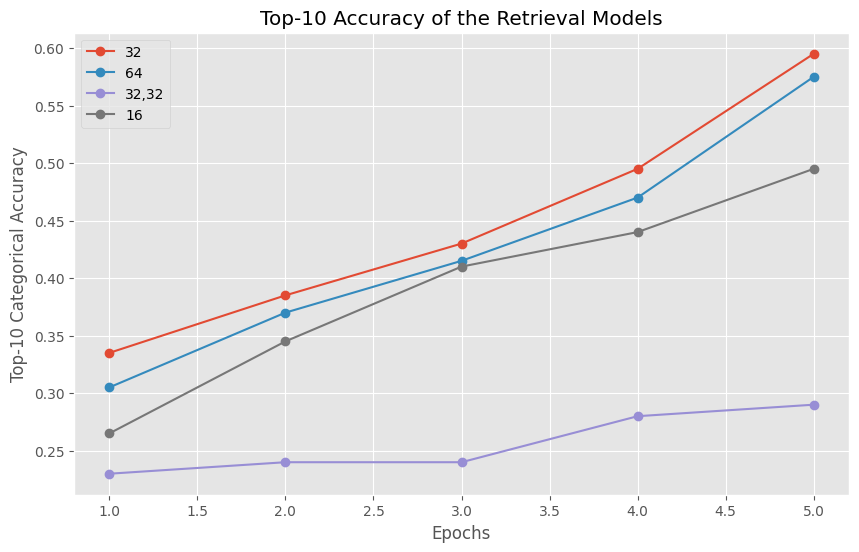

In [24]:
epochs = range(1,6)

plt.figure(figsize = (10,6))
plt.plot(epochs,retrieval_model1_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label = "32",marker = "o")
plt.plot(epochs,retrieval_model2_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label = "64",marker = "o")
plt.plot(epochs,retrieval_model3_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label = "32,32",marker = "o")
plt.plot(epochs,retrieval_model4_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label = "16",marker = "o")
plt.title("Top-10 Accuracy of the Retrieval Models")
plt.xlabel("Epochs")
plt.ylabel("Top-10 Categorical Accuracy")
plt.legend()
plt.show()

# 9. Ranking Model

In [25]:
ranking_dataset = tf.data.Dataset.from_tensor_slices({
    "reviewerID": reviews["reviewerID"].values,
    "product_id": reviews["product_id"].values,
    "summary": reviews["summary"].values,
    "overall": reviews["overall"].values
})

for i in ranking_dataset.take(1).as_numpy_iterator():
  print(i)

{'reviewerID': b'AO94DHGC771SJ', 'product_id': b'0528881469', 'summary': b'Gotta have GPS!', 'overall': 5.0}


In [26]:
ranking_dataset = ranking_dataset.shuffle(len(ranking_dataset),seed = 42)
train = ranking_dataset.take(int(len(ranking_dataset) * 0.8))
test = ranking_dataset.skip(int(len(ranking_dataset) * 0.8)).take(int(len(ranking_dataset) * 0.2))

In [27]:
class RankingModel(tf.keras.Model):
  def __init__(self,layer_sizes):
    super().__init__()

    self.product_id_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(vocabulary = unique_product_id),
        tf.keras.layers.Embedding(len(unique_product_id) + 1, 32)
    ])

    self.user_id_summary_embedding = UserModelFFN(layer_sizes)

    self.ranking_model = tf.keras.Sequential([tf.keras.layers.Dense(32,activation = "relu"),
                                              tf.keras.layers.Dense(16,activation = "relu"),
                                              tf.keras.layers.Dense(1)]) #output = (1,1)

  def call(self,inputs):
    return self.ranking_model(tf.concat([
                      self.product_id_embedding(inputs["product_id"]),
                      self.user_id_summary_embedding({"reviewerID": inputs["reviewerID"],"summary": inputs["summary"]})],axis = 1))

In [28]:
layer_sizes = [32]
print(RankingModel(layer_sizes)({"reviewerID": tf.constant([reviews["reviewerID"][0]]),
               "summary": tf.constant([reviews["summary"][0]]),
               "product_id": tf.constant([reviews["product_id"][0]])})) # output = (1,1)

print(tf.squeeze(RankingModel(layer_sizes)({"reviewerID": tf.constant([reviews["reviewerID"][0]]),
               "summary": tf.constant([reviews["summary"][0]]),
               "product_id": tf.constant([reviews["product_id"][0]])}))) # output = ()

tf.Tensor([[0.05720188]], shape=(1, 1), dtype=float32)
tf.Tensor(0.033990096, shape=(), dtype=float32)


In [29]:
class AmazonRankModel(tfrs.models.Model):
  def __init__(self,layer_sizes):
    super().__init__()

    self.ranking_model = RankingModel(layer_sizes)
    self.task = tfrs.tasks.Ranking(loss = tf.keras.losses.MeanSquaredError(),
                                   metrics = [tf.keras.metrics.RootMeanSquaredError()])

  def call(self,inputs):
    return tf.squeeze(self.ranking_model(inputs)) #output = ()

  def compute_loss(self,inputs,training = False):
    labels = inputs.pop("overall") #output = ()
    scores = self(inputs) #output = ()
    return self.task(labels = labels,predictions = scores)

In [30]:
layer_sizes = [32]
rank_model1 = AmazonRankModel(layer_sizes)
rank_model1.compile(optimizer = tf.keras.optimizers.Adagrad(0.1))
rank_model_history1 = rank_model1.fit(train.batch(32),epochs = 5,validation_data = test.batch(32))

Epoch 1/5
25/25 [==============================] - 2s 21ms/step - root_mean_squared_error: 1.8602 - loss: 3.3822 - regularization_loss: 0.0000e+00 - total_loss: 3.3822 - val_root_mean_squared_error: 1.0420 - val_loss: 2.1598 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.1598
Epoch 2/5
25/25 [==============================] - 0s 4ms/step - root_mean_squared_error: 1.0276 - loss: 1.0349 - regularization_loss: 0.0000e+00 - total_loss: 1.0349 - val_root_mean_squared_error: 0.6664 - val_loss: 0.3413 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.3413
Epoch 3/5
25/25 [==============================] - 0s 4ms/step - root_mean_squared_error: 0.6006 - loss: 0.3681 - regularization_loss: 0.0000e+00 - total_loss: 0.3681 - val_root_mean_squared_error: 0.3681 - val_loss: 0.0861 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0861
Epoch 4/5
25/25 [==============================] - 0s 4ms/step - root_mean_squared_error: 0.4187 - loss: 0.1731 - regularization_loss: 0.0

In [31]:
layer_sizes = [64]
rank_model2 = AmazonRankModel(layer_sizes)
rank_model2.compile(optimizer = tf.keras.optimizers.Adagrad(0.1))
rank_model_history2 = rank_model2.fit(train.batch(32),epochs = 5,validation_data = test.batch(32))

Epoch 1/5
25/25 [==============================] - 2s 20ms/step - root_mean_squared_error: 1.9745 - loss: 3.8014 - regularization_loss: 0.0000e+00 - total_loss: 3.8014 - val_root_mean_squared_error: 1.0886 - val_loss: 0.3482 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.3482
Epoch 2/5
25/25 [==============================] - 0s 4ms/step - root_mean_squared_error: 1.0857 - loss: 1.1683 - regularization_loss: 0.0000e+00 - total_loss: 1.1683 - val_root_mean_squared_error: 0.6955 - val_loss: 0.2667 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.2667
Epoch 3/5
25/25 [==============================] - 0s 4ms/step - root_mean_squared_error: 0.6162 - loss: 0.3826 - regularization_loss: 0.0000e+00 - total_loss: 0.3826 - val_root_mean_squared_error: 0.5214 - val_loss: 0.0828 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0828
Epoch 4/5
25/25 [==============================] - 0s 4ms/step - root_mean_squared_error: 0.4148 - loss: 0.1743 - regularization_loss: 0.0

In [32]:
layer_sizes = [32,32]
rank_model3 = AmazonRankModel(layer_sizes)
rank_model3.compile(optimizer = tf.keras.optimizers.Adagrad(0.1))
rank_model_history3 = rank_model3.fit(train.batch(32),epochs = 5,validation_data = test.batch(32))

Epoch 1/5
25/25 [==============================] - 2s 20ms/step - root_mean_squared_error: 2.0219 - loss: 4.0073 - regularization_loss: 0.0000e+00 - total_loss: 4.0073 - val_root_mean_squared_error: 1.2955 - val_loss: 2.7390 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.7390
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.1478 - loss: 1.3167 - regularization_loss: 0.0000e+00 - total_loss: 1.3167 - val_root_mean_squared_error: 0.8661 - val_loss: 0.4268 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.4268
Epoch 3/5
25/25 [==============================] - 0s 4ms/step - root_mean_squared_error: 0.9233 - loss: 0.8393 - regularization_loss: 0.0000e+00 - total_loss: 0.8393 - val_root_mean_squared_error: 0.6322 - val_loss: 0.2619 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.2619
Epoch 4/5
25/25 [==============================] - 0s 5ms/step - root_mean_squared_error: 0.5703 - loss: 0.3361 - regularization_loss: 0.0

In [33]:
layer_sizes = [16]
rank_model4 = AmazonRankModel(layer_sizes)
rank_model4.compile(optimizer = tf.keras.optimizers.Adagrad(0.1))
rank_model_history4 = rank_model4.fit(train.batch(32),epochs = 5,validation_data = test.batch(32))

Epoch 1/5
25/25 [==============================] - 3s 29ms/step - root_mean_squared_error: 1.8260 - loss: 3.2510 - regularization_loss: 0.0000e+00 - total_loss: 3.2510 - val_root_mean_squared_error: 1.1015 - val_loss: 0.4930 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.4930
Epoch 2/5
25/25 [==============================] - 0s 8ms/step - root_mean_squared_error: 1.0234 - loss: 1.0409 - regularization_loss: 0.0000e+00 - total_loss: 1.0409 - val_root_mean_squared_error: 0.6516 - val_loss: 0.4123 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.4123
Epoch 3/5
25/25 [==============================] - 0s 4ms/step - root_mean_squared_error: 0.7134 - loss: 0.5219 - regularization_loss: 0.0000e+00 - total_loss: 0.5219 - val_root_mean_squared_error: 0.7558 - val_loss: 0.4676 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.4676
Epoch 4/5
25/25 [==============================] - 0s 4ms/step - root_mean_squared_error: 0.5355 - loss: 0.2838 - regularization_loss: 0.0

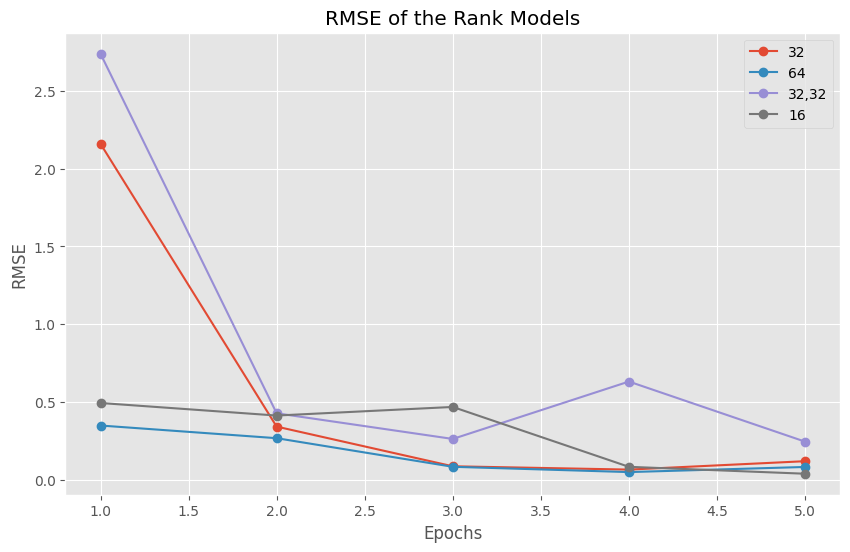

In [35]:
epochs = range(1,6)

plt.figure(figsize = (10,6))
plt.plot(epochs,rank_model_history1.history["val_total_loss"], label = "32",marker = "o")
plt.plot(epochs,rank_model_history2.history["val_total_loss"], label = "64",marker = "o")
plt.plot(epochs,rank_model_history3.history["val_total_loss"], label = "32,32",marker = "o")
plt.plot(epochs,rank_model_history4.history["val_total_loss"], label = "16",marker = "o")
plt.title("RMSE of the Rank Models")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()